In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip your data file into a new '/content/data/' directory
# This is much faster than reading from Drive directly
!unzip -q "/content/drive/My Drive/24548953.zip" -d "/content/data/"

print("Data successfully unzipped into /content/data/")

Mounted at /content/drive
Data successfully unzipped into /content/data/


In [2]:
# Unzip the main file first
!unzip -q "/content/drive/My Drive/24548953.zip" -d "/content/raw_data/"

# Now, unzip the nested files into class folders
# The -j flag flattens the directory structure, which is helpful here
!unzip -qj "/content/raw_data/Abnormal.zip" -d "/content/raw_data/abnormal/"
!unzip -qj "/content/raw_data/Normal.zip" -d "/content/raw_data/normal/"

print("All images have been unzipped into 'abnormal' and 'normal' folders.")

All images have been unzipped into 'abnormal' and 'normal' folders.


In [3]:
import os
import shutil
import random

# --- CONFIGURATION ---
# Path to your unzipped class folders (e.g., /content/raw_data)
source_dir = '/content/raw_data'

# Path where the new 'train', 'val', and 'test' folders will be saved
dest_dir = '/content/final_split_data'

# Split ratios
# 20% for the test set (kept separate)
test_ratio = 0.20
# Of the remaining 80%, 20% for validation (0.20 * 0.80 = 16% of total)
validation_ratio_from_remaining = 0.20
# --- END CONFIGURATION ---


# Create destination directories for all three splits
print("Creating destination directories...")
for split in ['train', 'val', 'test']:
    for class_name in ['abnormal', 'normal']:
        # This creates /content/final_split_data/train/abnormal, /val/abnormal, /test/abnormal, etc.
        os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)
print("Directories created.")

# This is the complete function to split the files
def split_files(class_name):
    print(f"Processing class: {class_name}")
    class_path = os.path.join(source_dir, class_name)

    if not os.path.isdir(class_path):
        print(f"Error: Source directory not found for class '{class_name}'. Skipping.")
        return

    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    if not files:
        print(f"Warning: No files found for class '{class_name}'.")
        return

    random.shuffle(files) # Shuffle the files randomly

    # --- STEP 1: Split 20% for Test Set ---
    total_files = len(files)
    test_split_point = int(total_files * test_ratio)

    # Files for the final, unseen test set
    test_files = files[:test_split_point]

    # Remaining files (80% of total) for training and validation
    remaining_files = files[test_split_point:]

    # --- STEP 2: Split remaining 80% into 80% Train and 20% Validation ---

    # Calculate validation split from the remaining files
    validation_split_point = int(len(remaining_files) * validation_ratio_from_remaining)

    # Files for validation (16% of total)
    val_files = remaining_files[:validation_split_point]

    # The rest are for training (64% of total)
    train_files = remaining_files[validation_split_point:]

    # Define all destination paths
    train_dest = os.path.join(dest_dir, 'train', class_name)
    val_dest = os.path.join(dest_dir, 'val', class_name)
    test_dest = os.path.join(dest_dir, 'test', class_name)

    # Function to copy files
    def copy_files(file_list, destination):
        for f in file_list:
            shutil.copy2(os.path.join(class_path, f), os.path.join(destination, f))

    # Copy all files
    copy_files(train_files, train_dest)
    copy_files(val_files, val_dest)
    copy_files(test_files, test_dest)

    print(f"  > Copied {len(train_files)} train images (64%)")
    print(f"  > Copied {len(val_files)} val images (16%)")
    print(f"  > Copied {len(test_files)} test images (20%)")
    print(f"  > Total files processed: {len(train_files) + len(val_files) + len(test_files)}")

# Run the split for both classes
split_files('abnormal')
split_files('normal')

print(f"\nData splitting complete! Your data is in '{dest_dir}' with 64/16/20 split.")

Creating destination directories...
Directories created.
Processing class: abnormal
  > Copied 788 train images (64%)
  > Copied 197 val images (16%)
  > Copied 246 test images (20%)
  > Total files processed: 1231
Processing class: normal
  > Copied 648 train images (64%)
  > Copied 161 val images (16%)
  > Copied 202 test images (20%)
  > Total files processed: 1011

Data splitting complete! Your data is in '/content/final_split_data' with 64/16/20 split.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import copy
import os

# IMPORTANT: Path to your unzipped data in Colab's local storage
data_dir = '/content/final_split_data/'

# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # --- ADDED: Transform for the Test Set (same as validation) ---
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets for train, val, AND test
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']} # <--- ADDED 'test'

# Create dataloaders for train, val, AND test
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=32,
                                              # Shuffle only the training data
                                              shuffle=(x == 'train'),
                                              num_workers=2)
               for x in ['train', 'val', 'test']} # <--- ADDED 'test'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Load and prepare the MobileNetV3 model
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)
)
model = model.to(device)

# Define loss, optimizer, and epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 25

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 134MB/s] 


In [6]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()
print(f'Training complete. Best val Acc: {best_acc:4f}')
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), '/content/drive/My Drive/mobilenet_v3_best_model.pth')
print("Best model saved to Google Drive!")

model.load_state_dict(best_model_wts)

Epoch 1/25
----------
train Loss: 0.5637 Acc: 0.6971
val Loss: 0.6069 Acc: 0.6732

Epoch 2/25
----------
train Loss: 0.4680 Acc: 0.7841
val Loss: 0.4948 Acc: 0.7486

Epoch 3/25
----------
train Loss: 0.4355 Acc: 0.7939
val Loss: 0.3616 Acc: 0.8603

Epoch 4/25
----------
train Loss: 0.4130 Acc: 0.8036
val Loss: 0.3478 Acc: 0.8715

Epoch 5/25
----------
train Loss: 0.4233 Acc: 0.8175
val Loss: 0.3129 Acc: 0.8911

Epoch 6/25
----------
train Loss: 0.3895 Acc: 0.8210
val Loss: 0.3016 Acc: 0.8827

Epoch 7/25
----------
train Loss: 0.3732 Acc: 0.8343
val Loss: 0.3124 Acc: 0.8883

Epoch 8/25
----------
train Loss: 0.3726 Acc: 0.8370
val Loss: 0.3464 Acc: 0.8520

Epoch 9/25
----------
train Loss: 0.3961 Acc: 0.8203
val Loss: 0.2951 Acc: 0.8939

Epoch 10/25
----------
train Loss: 0.3698 Acc: 0.8287
val Loss: 0.2899 Acc: 0.8911

Epoch 11/25
----------
train Loss: 0.3709 Acc: 0.8440
val Loss: 0.2815 Acc: 0.9134

Epoch 12/25
----------
train Loss: 0.3651 Acc: 0.8496
val Loss: 0.2739 Acc: 0.8966

E

<All keys matched successfully>

In [7]:
import torch

# This code runs after the training loop has finished and the 'model' has
# already been loaded with the best weights: model.load_state_dict(best_model_wts)

print("\n--- Final Test Set Evaluation ---")

# Ensure the model is in evaluation mode
model.eval()
# Ensure criterion is defined (it was defined in the setup cell)
# criterion = torch.nn.CrossEntropyLoss()

test_running_loss = 0.0
test_running_corrects = 0
total_samples = 0

# Loop over the test data (dataloaders['test'] must be defined)
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # loss = criterion(outputs, labels) # Calculate loss for completeness

        # Accumulate metrics
        # test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

# Calculate final accuracy
final_test_acc = test_running_corrects.double() / total_samples

print(f"\nTest Set Performance (20% of Original Data):")
print(f"Total Test Samples: {total_samples}")
print(f"Correct Predictions: {test_running_corrects}")
print(f"Final Unbiased Test Accuracy: {final_test_acc:.4f} ({(final_test_acc * 100):.2f}%)")


--- Final Test Set Evaluation ---

Test Set Performance (20% of Original Data):
Total Test Samples: 448
Correct Predictions: 404
Final Unbiased Test Accuracy: 0.9018 (90.18%)


In [8]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=eb9aba2f0db70afdcebc9501f25756fcc335c14a4cd0ced95109335b4c936cfa
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


Visualizing: /content/final_split_data/test/abnormal/Abnormal-0333.png


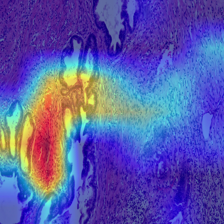

In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import os       # Added for file handling
import random   # Added for random selection

# 1. Unfreeze the target layer so Grad-CAM can calculate gradients
for param in model.features[-1].parameters():
    param.requires_grad = True

def visualize_gradcam(model, image_path, target_layer):
    model.eval()

    # 1. Prepare the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    # Convert to numpy and normalize to 0-1 for the visualization library
    rgb_img = np.float32(img) / 255
    # Apply standard transforms for the model input
    input_tensor = data_transforms['val'](Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)

    # 2. Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # 3. Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]

    # 4. Overlay heatmap on original image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 5. Display
    print(f"Visualizing: {image_path}")
    display(Image.fromarray(visualization))

# --- USAGE: RANDOM IMAGE SELECTION ---
# This replaces the hardcoded path with a random pick from your test set

# 1. Define the folder containing your abnormal test images
# (Matches the path from your data split step earlier)
test_abnormal_dir = '/content/final_split_data/test/abnormal/'

# 2. Pick a random file
random_image_name = random.choice(os.listdir(test_abnormal_dir))
full_image_path = os.path.join(test_abnormal_dir, random_image_name)

# 3. Run Grad-CAM on this random image
visualize_gradcam(model, full_image_path, model.features[-1])

Generating metrics on the Test Set...

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

    abnormal       0.92      0.90      0.91       246
      normal       0.88      0.91      0.89       202

    accuracy                           0.90       448
   macro avg       0.90      0.90      0.90       448
weighted avg       0.90      0.90      0.90       448

Confusion Matrix:


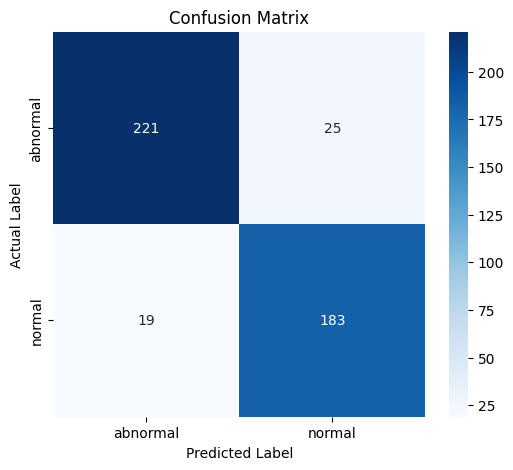

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# NOTE: We do NOT need to load from a file because 'model'
# in your notebook already holds the best weights from the training loop.

def evaluate_model_performance(model, dataloader, dataset_classes):
    model.eval() # Set to evaluation mode
    model.to(device)

    all_preds = []
    all_labels = []

    print("Generating metrics on the Test Set...")

    # Iterate over the test data
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Move data back to CPU for scikit-learn
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Classification Report (F1, Recall, Precision) ---
    print("\nClassification Report:")
    print("-" * 60)
    # Using the classes from your test set
    print(classification_report(all_labels, all_preds, target_names=dataset_classes))

    # --- Confusion Matrix ---
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset_classes,
                yticklabels=dataset_classes)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Run the function using your 'test' dataloader
evaluate_model_performance(model, dataloaders['test'], image_datasets['test'].classes)